<a href="https://colab.research.google.com/github/shaynyx/marvelLevel2/blob/main/task1L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np

In [36]:
data=pd.read_csv('PlayTennis.csv')

In [37]:
data.head()

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


#**Calculating the entropy of the whole dataset**

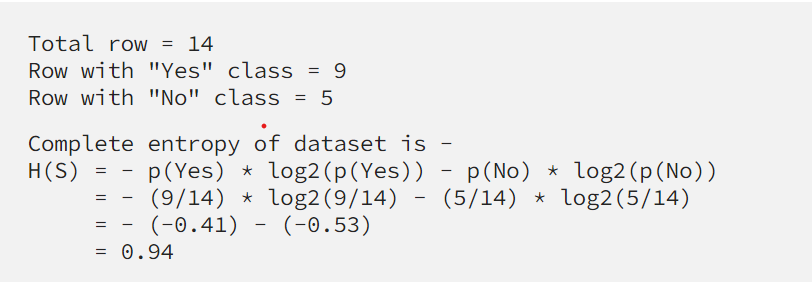

In [38]:

def calc_total_entropy(train_data, label, class_list):
    total_row = train_data.shape[0] #the total size of the dataset
    total_entr = 0

    for c in class_list: #for each class in the label
        total_class_count = train_data[train_data[label] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset

    return total_entr

# **Calculating the entropy for the filtered dataset**

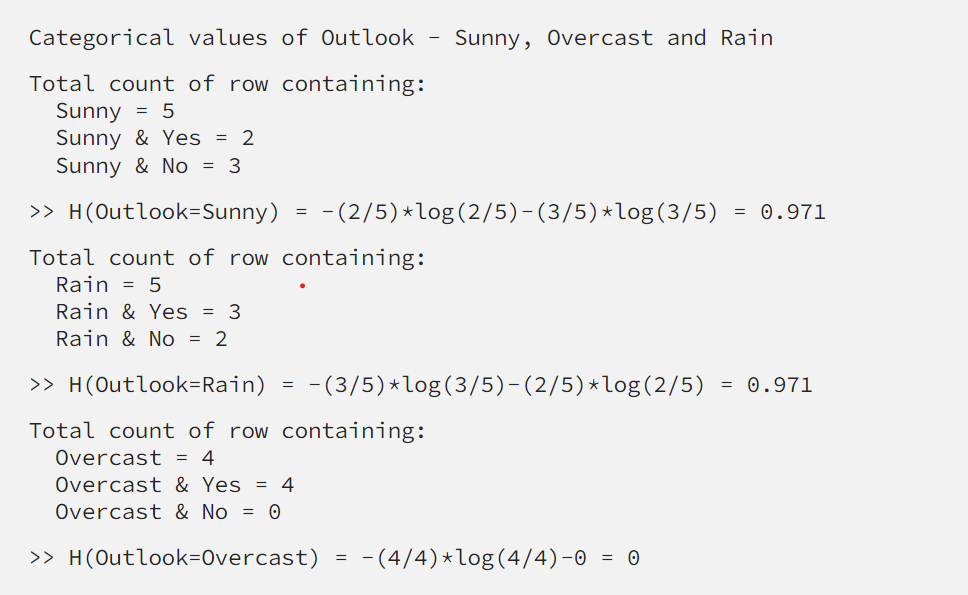

In [39]:

def calc_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0

    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy

# **Calculating information gain for a feature**

I(Outlook) = p(Sunny) * H(Outlook=Sunny) + p(Rain) * H(Outlook=Rain) + p(Overcast) * H(Outlook=Overcast)
= (5/14)*0.971 + (5/14)*0.971 + (4/14)*0
= 0.693


Information Gain = H(S) - I(Outlook)
                 = 0.94 - 0.693
                 = 0.247

In [40]:
def calc_info_gain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique() #unqiue values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0

    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = calc_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value

    return calc_total_entropy(train_data, label, class_list) - feature_info #calculating information gain by subtracting


# **Finding the most informative feature (feature with highest information gain)**

In [41]:
def find_most_informative_feature(train_data, label, class_list):
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
                                            #N.B. label is not a feature, so dropping it
    max_info_gain = -1
    max_info_feature = None

    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = calc_info_gain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature

    return max_info_feature

In [42]:

def generate_sub_tree(feature_name, train_data, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node

    for feature_value, count in feature_value_count_dict.iteritems():
        feature_value_data = train_data[train_data[feature_name] == feature_value] #dataset with only feature_name = feature_value

        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c

            if class_count == count: #count of (feature_value = count) of class (pure class)
                tree[feature_value] = c #adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #as feature_value is not a pure class, it should be expanded further,
                                      #so the branch is marking with ?

    return tree, train_data

In [43]:
def make_tree(root, prev_feature_value, train_data, label, class_list):
    if train_data.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature = find_most_informative_feature(train_data, label, class_list) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data, label, class_list) #getting tree node and updated dataset
        next_root = None

        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]

        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                make_tree(next_root, node, feature_value_data, label, class_list) #recursive c

In [44]:
def id3(train_data_m, label):
    train_data = train_data_m.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = train_data[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, train_data, label, class_list) #start calling recursion
    return tree

In [45]:
tree = id3(data, 'Play Tennis')

<ipython-input-42-b182bf0ec406>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():
<ipython-input-42-b182bf0ec406>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():
<ipython-input-42-b182bf0ec406>:5: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for feature_value, count in feature_value_count_dict.iteritems():


In [47]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

In [48]:
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows(): #for each row in the dataset
        result = predict(tree, test_data_m.iloc[index]) #predict the row
        if result == test_data_m[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy

In [50]:
test_data_m = pd.read_csv("PlayTennisTest.csv") #importing test dataset into dataframe

accuracy = evaluate(tree, test_data_m, 'Play Tennis') #evaluating the test dataset
accuracy

1.0